## Summary

Accompanying the global trend in the use of bicycles as a sustainable transport, Madrid is not an exception. Its sharing public system (Bicimad) has been growing considerably year by year in terms of users and uses. One of the main goals of the system is to attract those people who travel in private vehicles for internal displacements in the city and thereby reduce negative consequences of car travel such as pollution, noise, etc. To achieve these goals, one of the most important aspects to be considered is the correct location of bike stations in order to satisfy the demand that could exist.

While there are many factors to consider to establish an optimal system (exceeding this example), a **good starting point** is to understand how the bicycle network works today and which are either more or less influential stations of the network.

It is difficult to understand with the provided data how important each station is and how it affects the rest of the network. In order to get results, we thought it would be useful to represent data in graphs as is already used in multiple scenarios. 

Represent and organize data as graphs is really useful when you are trying to define relationships between different nodes and edges. The nodes or vertices are the entities which must be represented, while the edges or arcs define the relationships between those nodes. This type of data works very well for the analysis of social networks and implementation of algorithms such as PageRank to better understand and analyze the relationships between entities.

More use cases of data organized in graphs could be social networks, the articles' quality and importance in bibliographic sites and the classification of web sites.

**In this example, the implementation of the PageRank algorithm will be applied to Bicimad system**, using public data provided by the company to determine the influence of the nodes in the network. In this case, the nodes will be represented by the stations and each movement or trip will be represented by an arc connecting both stations. The weight of the arc is defined as the number of trips between stations, which will create a directed graph.


### Setting up

Data used for this example was obtained from public information sources, using the open data services provided by the EMT (Link) system and data for the period between April 2017 and January 2019.

We mainly used 2 data sources:

**Stations ([Link](https://rbdata.emtmadrid.es:8443/BiciMad/get_stations/WEB.SERV.gaston@gutrade.io/1326B978-2486-479C-B76E-15C4838F9345/))**
From each of the stations (172), the id, the name and other characteristics are stored in the *stations.csv* file that will be used later.

**Movements or trips ([Source](http://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)))**
In this case the information is related to the movements of bicycles. Understanding as movement, the travel of a bicycle from an origin station to a destination station. This information includes data related to the movement itself (departure station, destination) and data relating to the user who performs the movement. It also distinguishes between movements made by the users of the system and movements made by the workers whose job is to cover the demand in certain stations.
The ETL process involved the transformation of the original files into a manipulable format, cleaning and deleting some records as:
• Records with coordinates outside the limits of Madrid.
• Non-existent stations.
• Negative travel times

There are approximately 7 million trips stored for the indicated period in *movements.csv*

In [1]:
import pandas as pd
stations = pd.read_csv('stations.csv', index_col = False)
movements = pd.read_csv('https://gastonlegnani.s3-us-west-2.amazonaws.com/movements.csv', index_col = False)

In [4]:
#stations dataframe
stations.head()

,id,code_station,name,num_bases,address,latitude,longitude
0,1,1,Puerta del Sol A,24,Puerta del Sol nº 1,40.416896,-3.702425
1,2,2,Puerta del Sol B,24,Puerta del Sol nº 1,40.417001,-3.702421
2,3,3,Miguel Moya,24,Calle Miguel Moya nº 1,40.420589,-3.705842
3,4,4,Plaza Conde Suchil,18,Plaza del Conde Suchil nº 2-4,40.430294,-3.706917
4,5,5,Malasaña,24,Calle Manuela Malasaña nº 5,40.428552,-3.702587


In [2]:
#movements dataframe
movements.head()

,user_type_code,travel_time,idunplug_station,age_range_code,idplug_station,unplug_hourtime
0,1,169,41,4,50,2017-04-01 01:00
1,1,271,95,5,90,2017-04-01 01:00
2,1,171,15,4,16,2017-04-01 01:00
3,1,388,23,4,57,2017-04-01 01:00
4,1,381,23,4,43,2017-04-01 01:00


## Building the graph

Including some necessary libraries. Must have installed them first.

In [3]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import operator
import folium
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

Graph is generated. Nodes will represent the stations, using 'id' column as station's identifier.

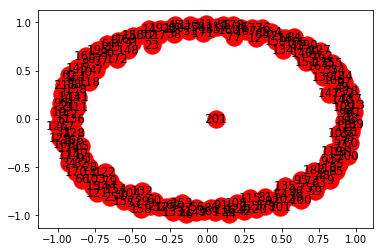

In [4]:
G = nx.Graph()
G.add_nodes_from([i for i in stations['id']])
nx.draw_networkx(G)
plt.show()

A weight is assigned to each edge. This weight represents the number of trips between both endpoints of the edge.

As the dataset (*movements*) contains unique records for each trip, it's necessary to group and count the movements between these stations, as it's been done below.

The movements are divided in two parts in order to perform an independent analysis on them:
* The users of the system (user_type_code = 0,1,2)
* Workers (user_type_code = 3) 


In [5]:
users_codes = [0,1,2]
workers_codes = [3]

mov_users = movements[movements.user_type_code.isin(users_codes)].groupby(['idunplug_station','idplug_station']).count().reset_index().loc[:, ["idunplug_station", "idplug_station", "user_type_code"]]
mov_users.columns = ['origin', 'destination', 'weight']

mov_workers = movements[movements.user_type_code.isin(workers_codes)].groupby(['idunplug_station','idplug_station']).count().reset_index().loc[:, ["idunplug_station", "idplug_station", "user_type_code"]]
mov_workers.columns = ['origin', 'destination', 'weight']

Now i can generate the graphs including the edges information. As previously mentioned, two graphs will be generated. One for the users and one for the workers of the company and they will be analyzed separately later.

In [6]:
G_users=nx.from_pandas_edgelist(mov_users, 'origin', 'destination', 'weight')
G_workers=nx.from_pandas_edgelist(mov_workers, 'origin', 'destination', 'weight')

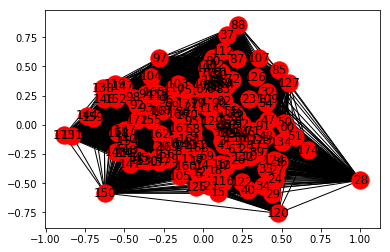

In [7]:
nx.draw_networkx(G_users)
plt.show()

## Implementing PageRank

PageRank works by counting the number and quality of links to a website in order to estimate the importance of its website. The underlying assumption is that the most important websites are likely to receive more links from others.

The interesting thing about this concept is that it can be applied to any graph structure, wether in web pages or in bicycle stations in this case. 

I'm going to use the NetworkX library imported previously. The algorithm was implemented on both generated graphs in order to analyze the most and least important stations of the network.

In [8]:
pr_users = nx.pagerank(G_users, alpha=0.85)
pr_workers = nx.pagerank(G_workers, alpha=0.85)

According to the algorithm and the analyzed period, the most important stations for users are:

In [9]:
sort_p_users=sorted(pr_users.items(),key=operator.itemgetter(1),reverse=True)
ids = [i[0] for i in sort_p_users[:10]]
top5_users = stations[stations.id.isin(ids)]
top5_users['rv'] = [i[1] for i in sort_p_users[:10]]
top5_users.loc[:, ['name', 'id', 'rv']]

,name,id,rv
41,Plaza de la Cebada,43,0.012899
55,Plaza de Lavapiés,57,0.012793
86,Puerta de Madrid,90,0.012658
125,Santa María de la Cabeza,129,0.010903
130,General Álvarez de Castro,163,0.010881
131,Fernando el Católico,168,0.010791
132,Cea Bermúdez,160,0.010423
136,Glorieta de los Cuatro Caminos,149,0.010234
169,Entrada Matadero,135,0.010020
171,Segovia 45,175,0.009967


For a better visualization, we might want to see them within a map

In [10]:
top5_users['geometry'] = list(zip(top5_users.longitude, top5_users.latitude))
top5_users['geometry'] = top5_users['geometry'].apply(Point)
crs = {'init': 'epsg:4326'}
top5_users_gdf = gpd.GeoDataFrame(top5_users, crs=crs, geometry='geometry')
m = folium.Map(location=[40.4, -3.7], zoom_start=12, tiles='cartodbpositron')
folium.GeoJson(top5_users_gdf, tooltip=folium.features.GeoJsonTooltip(fields=['id', 'name', 'num_bases', 'address'])).add_to(m)
m

**These stations are the natural connectors of the bicycle network.**

On the other hand, if we only consider workers movements, the most important stations of the network are:

In [11]:
sort_p_workers=sorted(pr_workers.items(),key=operator.itemgetter(1),reverse=True)
ids = [i[0] for i in sort_p_workers[:5]]
top5_workers = stations[stations.id.isin(ids)]
top5_workers['rv'] = [i[1] for i in sort_p_workers[:5]]
top5_workers.loc[:, ['name', 'id', 'rv']]

,name,id,rv
125,Santa María de la Cabeza,129,0.026770
144,Velázquez 130,162,0.020537
165,Paseo de la Florida,132,0.020255
166,Metro Pirámides,133,0.015130
169,Entrada Matadero,135,0.012951


**These stations are those where the workers either take out bicycles or put them back in during the day to cover the demand of the users of the network.**

For some reason these stations do not have a natural behavior given by the demand of the users. They are not considered to be mixed stations. They work as receivers (they receive a lot and therefore they have to be emptied) or issuers (many bicycles are taken out from there and as it gets empty, it must be filled)

### Less significant stations

* Considering users

In [13]:
ids = [i[0] for i in sort_p_users[-5:]]
less5_users = stations[stations.id.isin(ids)]
less5_users['rv'] = [i[1] for i in sort_p_users[-5:]]
less5_users.loc[:, ['name', 'id', 'rv']]

,name,id,rv
26,Plaza de Celenque A,28,0.002391
27,Plaza de Celenque B,29,0.002207
35,Carretas,37,0.002166
84,Pío Baroja,88,0.002148
115,Paseo de Moret,119,0.001640


Although we should analyze first the exact reason of the results, this information could be useful in order to reconsider either the correct location of the station or its existance.

* Considering workers

In [14]:
ids = [i[0] for i in sort_p_workers[-5:]]
less5_workers = stations[stations.id.isin(ids)]
less5_workers['rv'] = [i[1] for i in sort_p_workers[-5:]]
less5_workers.loc[:, ['name', 'id', 'rv']]

,name,id,rv
34,Plaza de la Provincia,36,0.003100
35,Carretas,37,0.003036
61,Plaza de Juan Pujol,63,0.002935
90,Conde Peñalver,94,0.002923
145,Pº Castellana - Glorieta de Emilio Castelar,165,0.002789


## Clustering

The goal here is to divide the graph into subnets or communities to find cohesive groups of stations in the network using the Louvain method. This information is useful as a starting point to develop a cycle infrastructure according to the user's behavior.

Community 0
[1, 3, 10, 13, 15, 16, 17, 18, 19, 24, 25, 26, 27, 28, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 62, 63, 71, 116, 119, 120, 121, 122, 123, 124, 128, 129, 132, 133, 134, 135, 136, 174, 175]
Community 1
[2, 21, 30, 32, 33, 64, 65, 66, 67, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 126, 127, 166, 170, 171]
Community 2
[4, 5, 6, 7, 8, 9, 11, 12, 14, 20, 58, 59, 61, 93, 117, 118, 125, 130, 131, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 172, 173]
Community 3
[23]


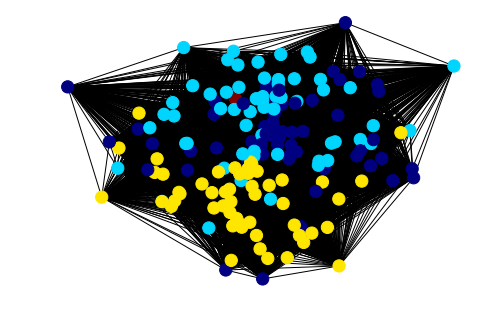

In [16]:
import community
partition = community.best_partition(G_users)
for i in set(partition.values()):
  print("Community", i)
  members = [nodes for nodes in partition.keys() if partition[nodes] == i]
  print(members)

values = [partition.get(node) for node in G_users.nodes()]
nx.draw(G_users, pos=nx.fruchterman_reingold_layout(G_users),
  cmap = plt.get_cmap('jet'),
  node_color = values,
  node_size=150,
  with_labels=False)

plt.show()

**We can see that according to this method there are 3-4 communities in the network**

For a better visualization we use a folium map.

In [17]:
def get_cluster_colour(community):
    if community == 0:
        return "green"
    if community == 1:
        return "blue"
    if community == 2:
        return "orange"
    else:
        return "red"

In [18]:
#Identifying stations according to the cluster and using different colours

m = folium.Map(location=[40.43, -3.7], zoom_start=13, tiles='cartodbpositron')
for i in set(partition.values()):
    ids = [nodes for nodes in partition.keys() if partition[nodes] == i]
    dat = stations[stations.id.isin(ids)]
    crs = {'init': 'epsg:4326'}
    for index, row in dat.iterrows():
        folium.Marker( location=[ row.latitude, row.longitude ], icon=folium.Icon(color=get_cluster_colour(i), icon='info-sign'), 
                  popup= str(row['name'])).add_to(m)
m

This information might mean that most of the user's movements are short in distance